In [124]:
import numpy as np
import time
import pickle
from scipy import misc
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
%matplotlib inline
# matplotlib.use('Qt5Agg')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
#import cvxpy as cp
from scipy.optimize import fsolve
from IPython.display import Markdown
# torch.set_default_dtype(torch.float64)
version = 1


# Price impact in the limit order book 

$\inf\left\{\mathbb{E}\left[\sum_{n=0}^{N} \left(D_n+\frac{\kappa}{2}x_n\right)x_n  \right]:\sum_{n=0}^N x_n = X_0\right\}$

$\inf\left\{\mathbb{E}\left[\sum_{n=0}^{N-1} \left(D_n+\frac{\kappa}{2}x_n\right)x_n  + \left(D_N+\frac{\kappa}{2}R_N\right)R_N\right]:x_0,...,x_N-1 \right\}$

$
\begin{cases}
R_{n+1} = R_{n} - x_n & R_0 = X_0\\
D_{n+1} = e^{-\rho\Delta t}\left(D_n + \kappa x_n\right) & D_0 = 0
\end{cases}
$


$V(t_m,D,R) = \inf\left\{\mathbb{E}\left[\sum_{n=m}^{N-1} \left(D_n+\frac{\kappa}{2}x_n\right)x_n  + \left(D_N+\frac{\kappa}{2}R_N\right)R_N\right]:x_m,...,x_N-1\right\}$


- DPP:
$V(t_n,D,R) = \inf\left\{\mathbb{E}\left[\left(D+\frac{\kappa}{2}x\right)x  + V\left(t_{n+1},e^{-\rho\Delta t}(D + \kappa x),R-x\right) \right]:x \right\}$


$V(T,D,R) = \left(D_N+\frac{\kappa}{2}R_N\right)R_N$

$V\left(t_{n+1},D,R\right)=A_{n+1} DR + B_{n+1}R^2 +C_{n+1}D^2$

$$
\begin{split}
V\left(t_{n+1},e^{-\rho\Delta t}(D + \kappa x),R-x\right) &= A_{n+1} e^{-\rho\Delta t}(D + \kappa x)(R-x) + B_{n+1}(R-x)^2 +C_{n+1}e^{-2\rho\Delta t}(D + \kappa x)^2\\
& = A_{n+1} e^{-\rho\Delta t}(DR + (\kappa R + D)x + \kappa x^2) + B_{n+1}(R^2-2xR+x^2) + C_{n+1}e^{-2\rho\Delta t}(D^2+2\kappa D x + \kappa^2 x^2)\\
& = A_{n+1} e^{-\rho\Delta t}DR + B_{n+1}R^2 + C_{n+1}e^{-2\rho\Delta t}D^2 + \left((A_{n+1} e^{-\rho\Delta t}\kappa -2B_{n+1}) R + (A_{n+1} e^{-\rho\Delta t}+2\kappa C_{n+1}e^{-2\rho\Delta t}) D \right)x + (A_{n+1} e^{-\rho\Delta t}\kappa + B_{n+1})x^2
\end{split}
$$

$$
\begin{split}
\left(D+\frac{\kappa}{2}x\right)x + V\left(t_{n+1},e^{-\rho\Delta t}(D + \kappa x),R-x\right) &= A_{n+1} e^{-\rho\Delta t}DR + B_{n+1}R^2 + C_{n+1}e^{-2\rho\Delta t}D^2 + \left((A_{n+1} e^{-\rho\Delta t}\kappa -2B_{n+1}) R + (A_{n+1} e^{-\rho\Delta t}+2\kappa C_{n+1}e^{-2\rho\Delta t}+1) D \right)x \\
&~~~~+ \left(A_{n+1} e^{-\rho\Delta t}\kappa + B_{n+1}+\frac{\kappa}{2}+C_{n+1}e^{-2\rho\Delta t}\kappa^2\right)x^2
\end{split}
$$

$x^*=-\frac12\dfrac{(A_{n+1} e^{-\rho\Delta t}\kappa -2B_{n+1}) R + (A_{n+1} e^{-\rho\Delta t}+2\kappa C_{n+1}e^{-2\rho\Delta t}+1) D}{A_{n+1} e^{-\rho\Delta t}\kappa + B_{n+1}+\frac{\kappa}{2}+C_{n+1}e^{-2\rho\Delta t}\kappa^2}$


$-\frac14\dfrac{\left((A_{n+1} e^{-\rho\Delta t}\kappa -2B_{n+1}) R + (A_{n+1} e^{-\rho\Delta t}+2\kappa C_{n+1}e^{-2\rho\Delta t}+1) D\right)^2}{A_{n+1} e^{-\rho\Delta t}\kappa + B_{n+1}+\frac{\kappa}{2}+C_{n+1}e^{-2\rho\Delta t}\kappa^2}$



$$
\begin{split}
\inf_{x} \left(D+\frac{\kappa}{2}x\right)x + V\left(t_{n+1},e^{-\rho\Delta t}(D + \kappa x),R-x\right)  =  A_{n+1} e^{-\rho\Delta t}DR + B_{n+1}R^2 + C_{n+1}e^{-2\rho\Delta t}D^2 -\frac14\dfrac{\left((A_{n+1} e^{-\rho\Delta t}\kappa -2B_{n+1}) R + (A_{n+1} e^{-\rho\Delta t}+2\kappa C_{n+1}e^{-2\rho\Delta t}+1) D\right)^2}{A_{n+1} e^{-\rho\Delta t}\kappa + B_{n+1}+\frac{\kappa}{2}+C_{n+1}e^{-2\rho\Delta t}\kappa^2}
\end{split}
$$







# Parameters


In [125]:
lob_params = {
    'T':1,#time horizon
    'mu':.3,
    'gamma':.0,#permanent price impact zero
    'kappa':1.,#temporary price impact
    'rho':5.,#resilience rate
    'sigma':.03,#volatility
    'mu':.3,#drift
    'A0':0.,# initial asset price
    'initial_balance':1e2,# initial balance
    'dim':3,# dimension of the state space (time, inventory, price impact)
}
approx_params = {
    'num_trajectories': 500,#  number of simulated trajectories
    'num_epochs': 5000, # number of epochs for training
    'num_time_steps': 10, # number of time steps in each trajectory
    'num_neurons': 16,# number of neurons in the hidden layers
}

# Closed-form

In [126]:
class solution(object):
    def __init__(self,lob_params,approx_params):
        self.num_steps = approx_params['num_time_steps']
        self.T = lob_params['T']
        self.rho = lob_params['rho']
        self.kappa = lob_params['kappa']
        self.delta = self.T/self.num_steps
        self.alpha=np.exp(-self.rho*self.delta)
    def optimal(self,x_init):
        t = torch.tensor([i*self.delta for i in range(self.num_steps+1)])
        for i in range(x_init.shape[0]):
            if i==0:
                trade = ((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.num_steps*self.delta,0,1))*self.alpha)*x_init[i]/((self.num_steps-1)*(1-self.alpha)+2)).unsqueeze(0)
            else:
                trade = torch.cat((trade,((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.num_steps*self.delta,0,1))*self.alpha)*x_init[i]/((self.num_steps-1)*(1-self.alpha)+2)).unsqueeze(0)),axis=0)
        return trade
    def __call__(self, x):
        exec =  self.optimal(x)   
        c_tmp = torch.tensor([0.0])
        D_tmp = torch.tensor([0.0])
        for i in range(self.num_steps+1):
            c_tmp = c_tmp + D_tmp*exec[:,i]+(self.kappa/2.0)*np.power(exec[:,i],2)
            D_tmp = (D_tmp + self.kappa * exec[:,i])*self.alpha
        return c_tmp

# Coarse PGM

## Neural net for trading

In [127]:
class trade_net(nn.Module): #NN for trading strategy
    def __init__(self,params):
        self.dim = 3
        self.num_neurons = params['num_neurons']
        super(trade_net, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(self.dim, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])      

## Neural net for value function 

In [128]:
class value_fnc(nn.Module): #NN for trading strategy
    def __init__(self,params):
        self.dim = 3
        self.num_neurons = params['num_neurons']
        super(value_fnc, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(self.dim, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])      

In [141]:
class optimal_execution(object):
    def __init__(self,lob_params,approx_params):
        self.epoch = 0
        self.loss_epoch=[]
        self.M = approx_params['num_trajectories']
        self.N = approx_params['num_time_steps']
        self.dim = approx_params['num_neurons']
        self.T = lob_params['T']
        self.sigma = lob_params['sigma']
        self.mu = lob_params['mu']
        self.A0 =lob_params['A0'] #initial fundamental price
        self.gamma = lob_params['gamma'] # permanent price impact
        self.kappa = lob_params['kappa'] #price impact coeff
        self.rho = lob_params['rho'] #resillience
        self.X0 = lob_params['initial_balance'] #initial balance
        self.neuron_model_psi = approx_params['num_neurons']
        self.delta = self.T/self.N
        self.alpha = np.exp(-self.rho*self.delta)
        self.trade_size = trade_net(approx_params)
        self.V = value_fnc(approx_params)
        t=torch.zeros([self.M,1])
        D=torch.zeros([self.M,1]) # we require to choose more intitial values for D and R
        R=self.X0*0.9+(self.X0*1.5-self.X0*0.5)*torch.rand(self.M,1)  #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        self.x=torch.cat((t,D,R),dim=1)
        self.trained = False
        self.exit_dict = lob_params.copy() | approx_params.copy() # shallow copy of param dicts for exit dictionary
        self.cf = solution(lob_params, approx_params)#closed-form solution
    
    # def terminal_cost(self,x):
    #     # terminal cost function
    #     # x[:,2] is the remaining balance R_t
    #     loss = (x[:,1]+self.kappa/2.0*x[:,2])*x[:,2]
    #     return loss
        
        
        
    # undate state process for one step
    def update(self,x,psi):
        t=(x[:,0]+self.delta)
        D = (x[:,1]+self.kappa*psi)*self.alpha
        R= x[:,2]-psi
        up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
        return up
    # running cost function for one step
    def step_cost(self,x,psi):
        loss=(x[:,1]*psi+(self.kappa/2.0)*torch.pow(psi,2))
        return loss
    # summarize the trade size, cost and update for one step
    def unit(self,x):
        psi=self.trade_size(x).squeeze(1)
        loss=self.step_cost(x,psi)
        upd=self.update(x,psi)
        return psi, loss, upd
    # total cost
    def cost(self,x):
        cost=torch.zeros(x.shape[0],self.N+1)
        psi=torch.zeros(x.shape[0],self.N)
        u=x
        for i in range(self.N+1):
            if(i!=self.N):
                psi_run,loss_run,u_run = self.unit(u)
                #print('los func=',psi_run.shape,loss_run.shape)
                cost[:,i] = loss_run
                #print(loss)
                psi[:,i] = psi_run
                #print(psi)
                u = u_run
                #print(u)
            else:
                # print(torch.sum(psi,dim=1).shape,x[:,2].shape)
                # psi_ter=x[:,2]-torch.sum(psi,dim=1)
                # psi_ter = u[:,2]
                cost[:,i]=self.step_cost(u,u[:,2])
                #print('ter',loss_ter.shape)
        cost=torch.sum(cost,dim=1)
        #print(loss.shape)
        return cost
    
    def train(self, lr, err, num_epochs):
        start=time.time()
        # lr = 8e-3
        epoch=self.epoch
        # num_epochs=500
        L_=0.1
        optimizer = optim.Adam(self.trade_size.parameters(), lr)
        L=100000
        while (np.abs(L_-L)/np.abs(L_)>err) &  (epoch <= num_epochs):
            t0 = time.time()
            optimizer.zero_grad()
            cost=self.cost(self.x)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            L = loss.clone().detach().numpy()
            self.loss_epoch.append(L)
            if epoch>0:
                L_ = self.loss_epoch[epoch-1]
            if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
                print("At epoch {:,} the mean cost is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch+1,loss.detach(),1000*(time.time()-t0)))            
            epoch=epoch+1
        end=time.time()
        print('time elapsed = {:.2e} ms'.format((end-start)*1000))
        print("Relative change in loss = %{:.7E} , last epoch = {}.".format((100*np.abs(L_-L)/np.abs(L_)),epoch+1))        
     
        self.epoch = epoch
        self.exit_dict['loss_log'] = self.loss_epoch
        self.exit_dict['last_epoch'] = epoch-1
        self.exit_dict['relative change in loss'] = (np.abs(L_-L)/np.abs(L_))
        self.exit_dict['execution_time'] = (end-start)*1000
        
        self.trained = True
        self.exit_dict['optimal_strategy'] = self.trade_size
        self.value()#  Must be after the line above.
        self.exit_dict['data'] = [self.x_data,self.y_data]#  Must be after the line above.
        self.exit_dict['value'] = self.V
        #testing
        t=torch.zeros([self.M,1])
        D=torch.zeros([self.M,1])
        test_init = self.X0*0.9+(self.X0*1.1-self.X0*0.9)*torch.rand(self.M,1)
        x_test=torch.cat((t,D,test_init),dim=1)
        L1_rel_err = torch.mean(torch.abs(self.cf(test_init)-self.cost(x_test).squeeze(-1)))/torch.mean(torch.abs(self.cf(test_init)))*100
        L_inf_err = torch.max(torch.abs(self.cf(test_init)-self.cost(x_test).squeeze(-1)))
        self.exit_dict['sup_error'] = L_inf_err
        self.exit_dict['rel_L1_error'] = L1_rel_err        
        
    def gen_data(self):
        if self.trained:
            cost=torch.zeros(self.M,self.N+1)
            psi=torch.zeros(self.M,self.N)
            u=self.x
            self.x_data = u
            for i in range(self.N+1):
                if(i!=self.N):
                    if i >0:
                        self.x_data = torch.cat((self.x_data,u),axis=0)
                    psi_run,loss_run,u_run=self.unit(u) 
                    #print('los func=',psi_run.shape,loss_run.shape)
                    cost[:,i]=loss_run
                    #print(loss)
                    psi[:,i]=psi_run
                    #print(psi)
                    u=u_run
                    #print(u)
                else:
                    # print(torch.sum(psi,dim=1).shape,x[:,2].shape)
                    # psi_ter=self.x[:,2]-torch.sum(psi,dim=1)
                    cost[:,i]=self.step_cost(u,u[:,2])
                    self.x_data = torch.cat((self.x_data,u),axis=0)
                    #print('ter',loss_ter.shape)
            self.y_data=torch.sum(cost,dim=1).unsqueeze(-1)
            for i in range(self.N):
                self.y_data = torch.cat((self.y_data,torch.sum(cost[:,i+1:],dim=1).unsqueeze(-1)),axis=0)
            # random shuffling of indeces for training
            r = torch.randperm(self.x_data.shape[0])
            self.x_data = self.x_data[r,:].clone().detach()
            self.y_data = self.y_data[r,:].clone().detach()  
            self.exit_dict['data'] = self.x_data     
        else:
            self.train(8e-3,1e-7,3000)
            self.gen_data()        
            
    def value(self):
        self.gen_data()
        lr = 8e-3
        num_batches = 1
        epoch=0
        loss_epoch = []
        num_epochs = 3000
        L_=torch.tensor([1.])
        loss = torch.tensor([1000.])
        optimizer = optim.Adam(self.V.parameters(), lr)
        err = 1e-3
        mse = nn.MSELoss()
        batch_size = int(self.x_data.shape[0]/num_batches)
        batch_epochs = int(num_epochs/num_batches)
        b=0
        x = self.x_data
        t = sorted(list(set(x[:,0].numpy())))
        ind = x[:,0]<=t[3]
        x_true = x[ind]
        y_true = self.y_data[ind]
        print("Building value functin...")
        # while i < num_batches:
        while (torch.abs(L_-loss)>err) &  (epoch <= num_epochs):
            start = time.time()
            optimizer.zero_grad()
            index = [b*batch_size, self.x_data.shape[0]] if (b+1==num_batches) else [b*batch_size, (b+1)*batch_size]
            # x_true = self.x_data[index[0]:index[1],:]
            # y_true = self.y_data[index[0]:index[1],:]
            loss = mse(self.V(x_true),y_true)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss)
            if epoch>0:
                L_ = loss_epoch[epoch-1]
            # if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
            #     print("At epoch {:,} mse in approximating the value function is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch+1,loss.detach(),1000*(time.time()-t0)))
            epoch=epoch+1
            if epoch == (b+1)*batch_epochs:
                print("At epoch {:,} batch {} is used.".format(epoch+1,b+2))
            if epoch >= (b+1)*batch_epochs:
                b = b + 1
        end=time.time()
        print('time elapsed = {:.2e} ms'.format((end-start)*1000))
        print("Change in mse of the value function is %{:.7E}.".format((100*torch.abs(L_-loss).item())))
             
            
        
    def __call__(self,x_init):
        t = torch.tensor([i*self.delta for i in range(self.N+1)])
        for i in range(x_init.shape[0]):
            if i==0:
                trade = ((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.N*self.delta,0,1))*self.alpha)*x_init[i]/((self.N-1)*(1-self.alpha)+2)).unsqueeze(0)
            else:
                trade = torch.cat((trade,((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.N*self.delta,0,1))*self.alpha)*x_init[i]/((self.N-1)*(1-self.alpha)+2)).unsqueeze(0)),axis=0)
        return trade            
                    


In [142]:
oe = optimal_execution(lob_params,approx_params)

In [143]:
oe.train(8e-3,1e-9,3000)

At epoch 1 the mean cost is 1.0111975586E+04.  Epoch training time = 1.02E+01 ms
At epoch 600 the mean cost is 3.0128962402E+03.  Epoch training time = 5.19E+00 ms
At epoch 1,200 the mean cost is 2.9625385742E+03.  Epoch training time = 3.58E+00 ms
time elapsed = 6.15e+03 ms
Relative change in loss = %0.0000000E+00 , last epoch = 1580.
Building value functin...
At epoch 3,001 batch 2 is used.
time elapsed = 5.60e+00 ms
Change in mse of the value function is %3.7246094E+03.


In [146]:
oe.value()

Building value functin...
At epoch 3,001 batch 2 is used.
time elapsed = 1.35e+01 ms
Change in mse of the value function is %1.0308838E+01.


In [147]:
t=torch.zeros([oe.M,1])
D=torch.zeros([oe.M,1])
test_init = oe.X0*0.9+(oe.X0*1.1-oe.X0*0.9)*torch.rand(oe.M,1)
x_test=torch.cat((t,D,test_init),dim=1)
rel_err = torch.mean(torch.abs(oe.cf(test_init)-oe.cost(x_test).squeeze(-1)))/torch.mean(torch.abs(oe.cf(test_init)))*100
err = torch.mean(torch.abs(oe.cf(test_init)-oe.cost(x_test).squeeze(-1)))
torch.mean(torch.abs(oe.cf(test_init)))

tensor(1447.7112)

In [148]:
Markdown(r"Relative $L^1$ error of trading cost compared to closed-form solution is %{:.2E}.".format(oe.exit_dict['rel_L1_error'].item()))

Relative $L^1$ error of trading cost compared to closed-form solution is %8.73E-01.

In [149]:
Markdown(r"$L^1$ error of trading cost compared to closed-form solution is \${:.7E}.".format(err.item()))

$L^1$ error of trading cost compared to closed-form solution is \$1.2915366E+01.

/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_62167/2075708329.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xyz[:,1], xyz[:,2], xyz[:,3],c=c,s=1,alpha=0.5,marker='o', label='est. t={:.2f}'.format(t[i]));
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_62167/2075708329.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xyu[:,1], xyu[:,2], xyu[:,3],c=c,s=5,alpha=0.1,marke

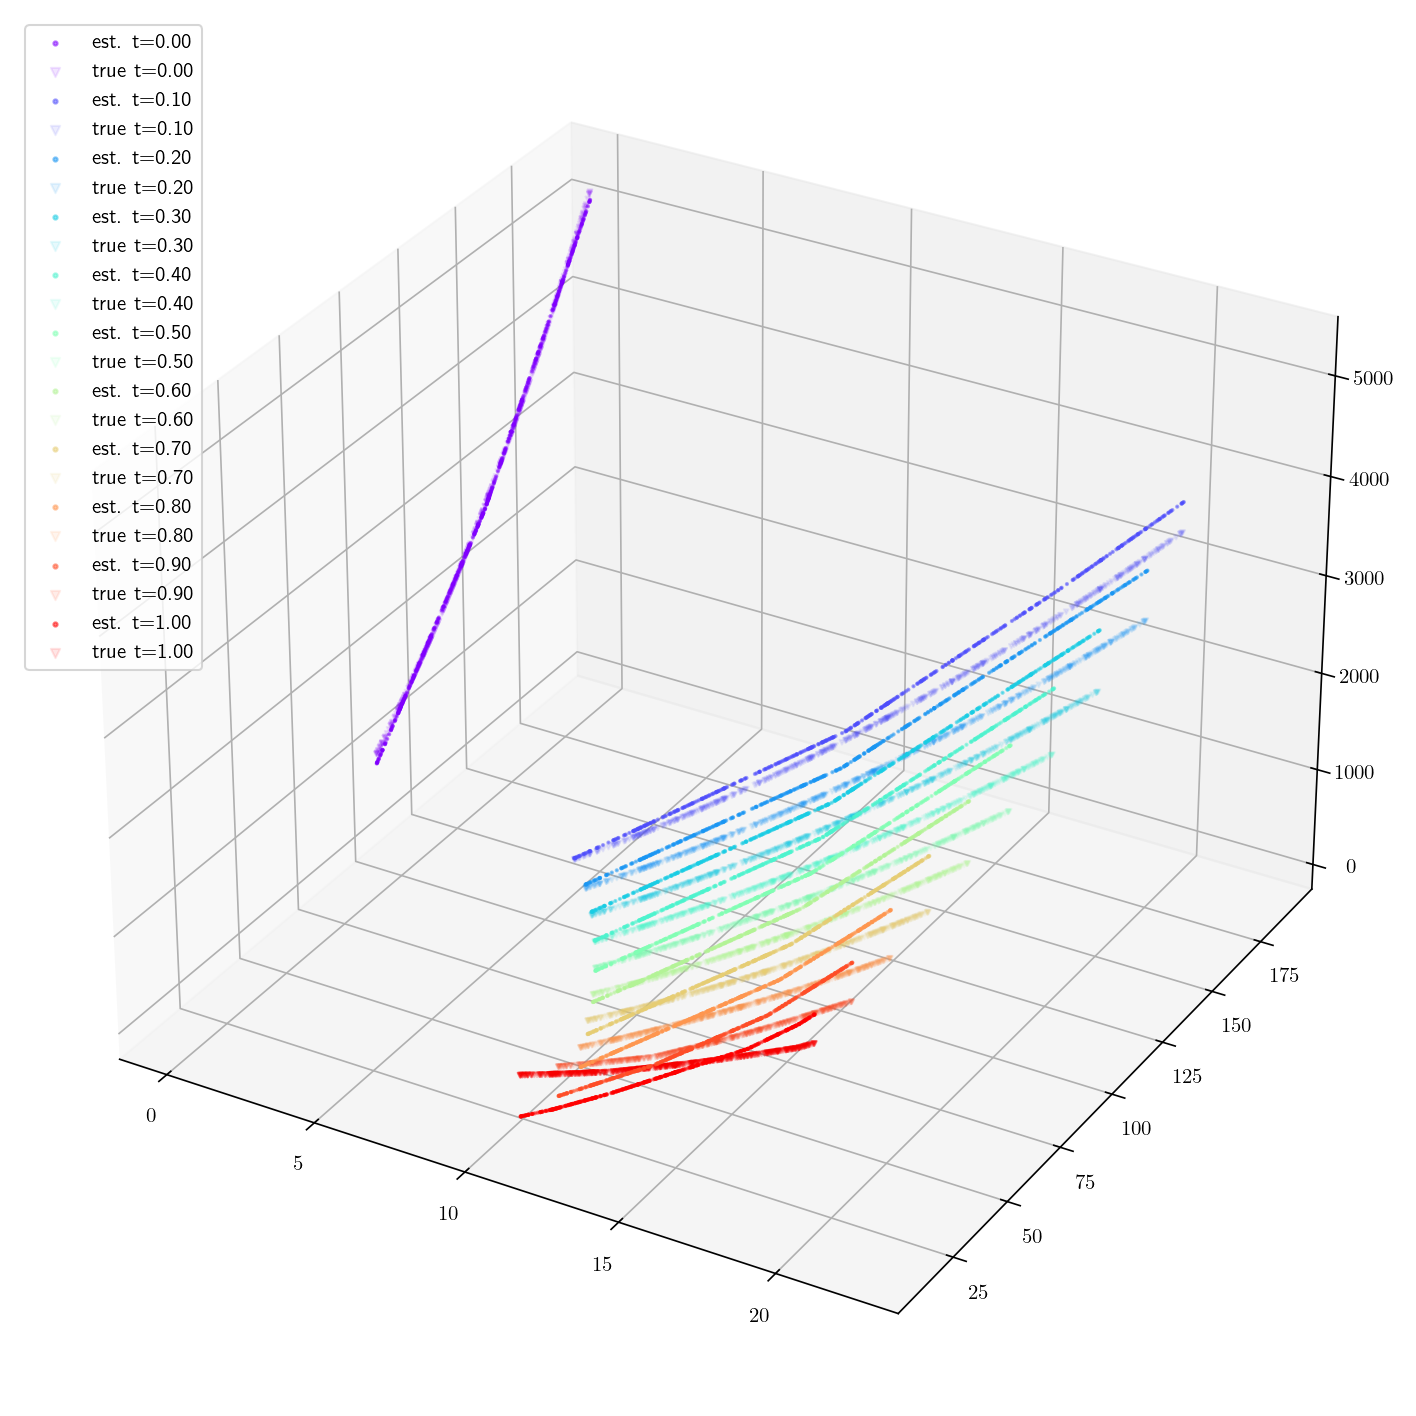

In [150]:
x = oe.x_data
t = sorted(list(set(x[:,0].numpy())))
color = plt.cm.rainbow(np.linspace(0, 1, oe.N+1))
fig = plt.figure(figsize=(12, 12), dpi=150)
ax = fig.add_subplot(projection='3d')
for i,c in enumerate(color):
    xy = x[x[:,0]==t[i]]
    z = oe.V(xy)
    xyz = torch.cat((xy,z),axis=1).detach().numpy()
    ax.scatter(xyz[:,1], xyz[:,2], xyz[:,3],c=c,s=1,alpha=0.5,marker='o', label='est. t={:.2f}'.format(t[i]));
    u = oe.cost(xy).unsqueeze(-1)
    xyu = torch.cat((xy,u),axis=1).detach().numpy()
    ax.scatter(xyu[:,1], xyu[:,2], xyu[:,3],c=c,s=5,alpha=0.1,marker='v', label='true t={:.2f}'.format(t[i]));
    
cl = xy[:,2]*(xy[:,1]+oe.kappa/2.0*xy[:,2])
ax.scatter(xyu[:,1], xyu[:,2], xyu[:,3],c=c,s=5,alpha=0.1,marker='v');
plt.legend(loc='upper left', fontsize=10, markerscale=2);

In [ ]:
x = oe.x_data
x_true = x[x[:,0]==0]
x_true

tensor([[  0.0000,   0.0000, 163.1078],
        [  0.0000,   0.0000, 133.5619],
        [  0.0000,   0.0000, 146.1435],
        ...,
        [  0.0000,   0.0000, 178.0506],
        [  0.0000,   0.0000, 124.6446],
        [  0.0000,   0.0000, 152.0340]])

In [ ]:
oe.y_data.shape,oe.cost(x_true).shape

(torch.Size([11000, 1]), torch.Size([1000]))

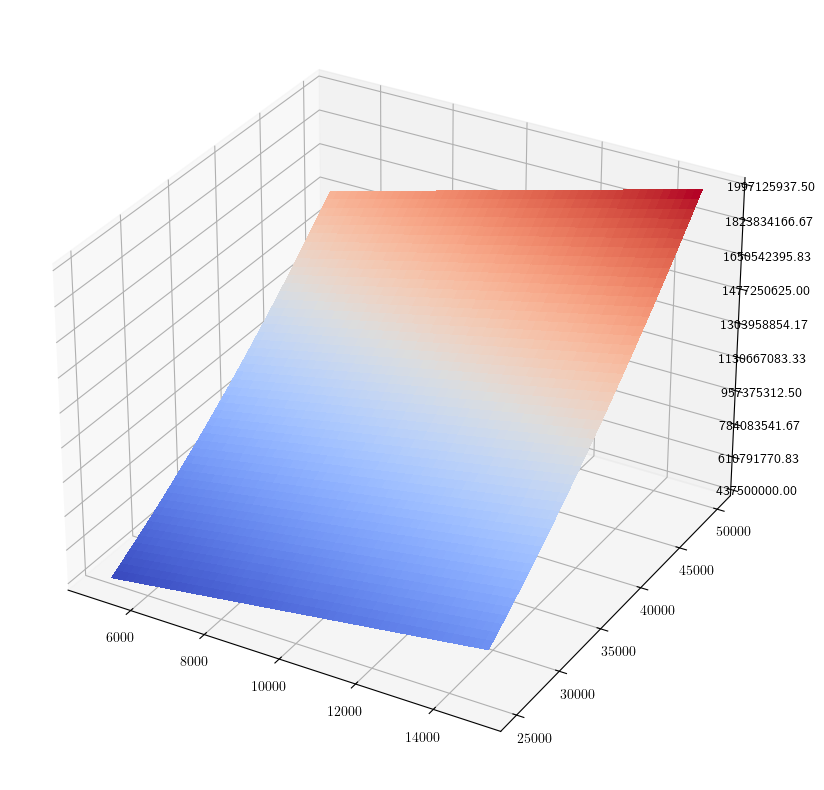

In [ ]:

fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(5000, 15000, 25)
Y = np.arange(25000, 50000, 25)
X, Y = np.meshgrid(X, Y)
Z = Y*(X+oe.kappa/2.0*Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
t=torch.zeros([1,1])
D=torch.zeros([1,1])
test_init = torch.tensor([[oe.X0]])
x_test=torch.cat((t,D,test_init),dim=1)

In [ ]:
oe.cf(test_init),oe.cost(x_test)

(tensor([1449.6171]), tensor([1449.6989], grad_fn=<SumBackward1>))